In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from tqdm.notebook import tqdm

from sklearn.manifold import TSNE

In [ ]:
from torchvision.datasets import MNIST
from torchvision import transforms

from torch.utils.data import DataLoader

mnist_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
batch_size = 64

In [ ]:
train_dataset = MNIST('./mnist_root', train=True, transform=mnist_transforms, download=True)
test_dataset = MNIST('./mnist_root', train=False, transform=mnist_transforms, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 12544882.83it/s]


Extracting ./mnist_root/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_root/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 503716.23it/s]


Extracting ./mnist_root/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_root/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1514495.99it/s]


Extracting ./mnist_root/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_root/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3493586.79it/s]

Extracting ./mnist_root/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_root/MNIST/raw



# Simple AE

In [ ]:
class Block(nn.Module):
    def __init__(self, in_features, out_features, kernel, stride=1, bias=False, upsample=False):
        super().__init__()
        self.upsample = upsample

        self.conv = nn.Conv2d(in_features, out_features, kernel, stride=stride, padding=(kernel-1)//2, bias=bias)
        self.norm = nn.BatchNorm2d(out_features)
        self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        if self.upsample:
            x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False, recompute_scale_factor=False)
        return self.act(self.norm(self.conv(x)))

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            Block(1, 16, 3, stride=2),
            Block(16, 32, 3, stride=2),
            Block(32, 32, 3, stride=2),
            Block(32, 32, 3, stride=2),
            Block(32, 32, 3, stride=1).conv,
        )

        self.decoder = nn.Sequential(
            Block(32, 32, 3, upsample=True),
            Block(32, 32, 3, upsample=True),
            Block(32, 32, 3, upsample=True),
            Block(32, 16, 3, upsample=True),
            Block(16, 1, 3).conv,
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = torch.sigmoid(x)
        return x

    def get_latent_features(self, x):
        return self.encoder(x)

In [ ]:
ae = AutoEncoder().to(device)
optim = torch.optim.Adam(ae.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [ ]:
tsne = TSNE()
ae.eval()

latent_mnist = [
    ae.get_latent_features(x.to(device)).detach().to('cpu').view(batch_size, -1) for x, _ in tqdm(test_loader)
]
latent_mnist = torch.cat(latent_mnist, dim=0).numpy()

  0%|          | 0/156 [00:00<?, ?it/s]

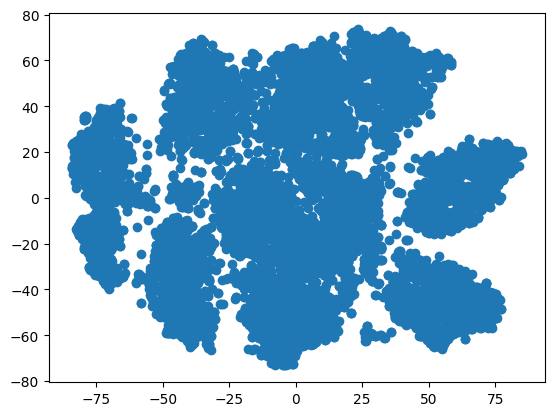

CPU times: user 1min 31s, sys: 644 ms, total: 1min 32s
Wall time: 1min 33s


In [ ]:
%%time

tsne_mnist = tsne.fit_transform(latent_mnist)
plt.scatter(tsne_mnist[:, 0], tsne_mnist[:, 1])
plt.show()

train loop:   0%|          | 0/937 [00:00<?, ?it/s]

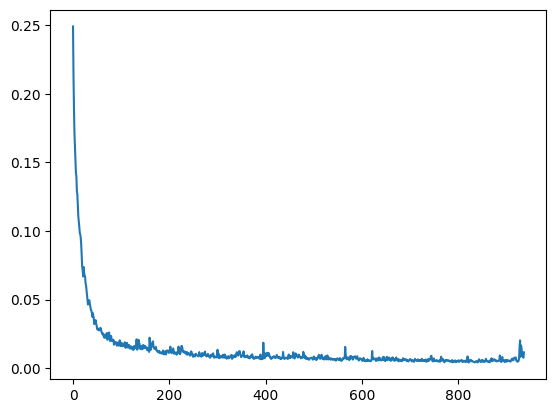

In [ ]:
losses = []
ae.train()

for image, _ in tqdm(train_loader, desc='train loop', leave=True):
    optim.zero_grad()
    image = image.to(device)
    out = ae(image)
    loss = criterion(out, image)
    loss.backward()
    optim.step()
    losses.append(loss.item())
plt.plot(losses)
plt.show()

  0%|          | 0/156 [00:00<?, ?it/s]

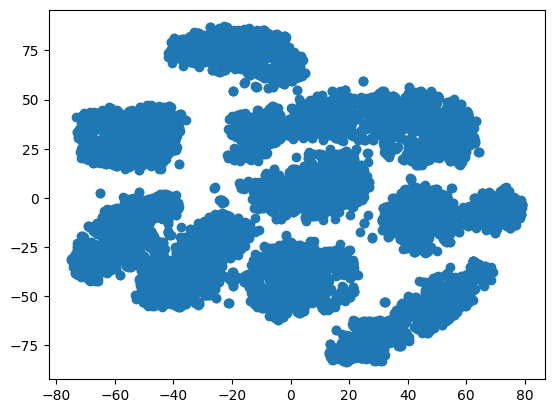

In [ ]:
tsne = TSNE()
ae.eval()


latent_mnist = [
    ae.get_latent_features(x.to(device)).detach().to('cpu').view(batch_size, -1) for x, _ in tqdm(test_loader)
]
latent_mnist = torch.cat(latent_mnist, dim=0).numpy()
tsne_mnist = tsne.fit_transform(latent_mnist)

plt.scatter(tsne_mnist[:, 0], tsne_mnist[:, 1])
plt.show()

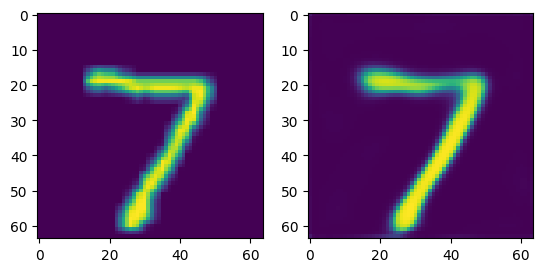

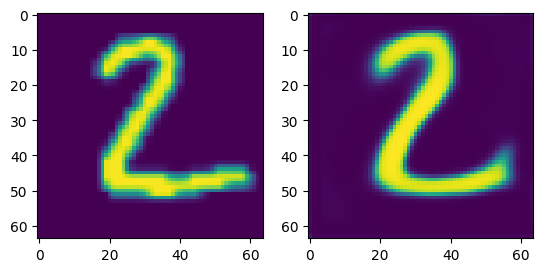

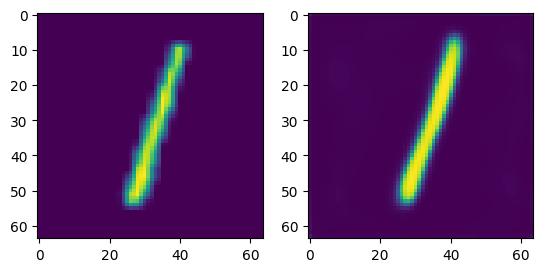

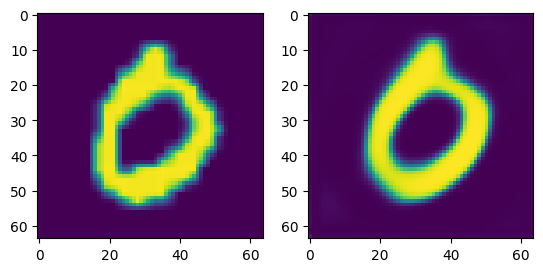

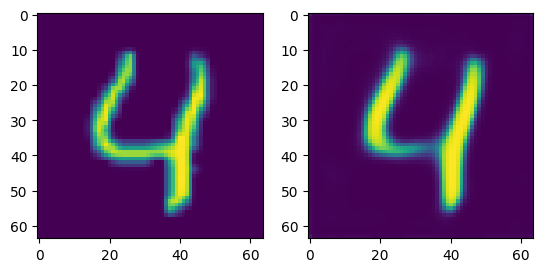

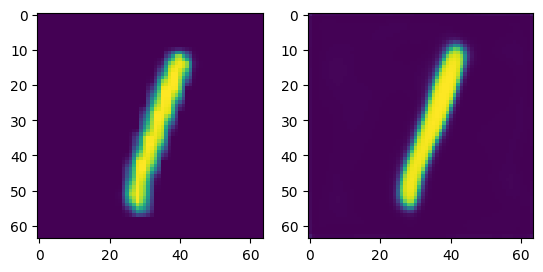

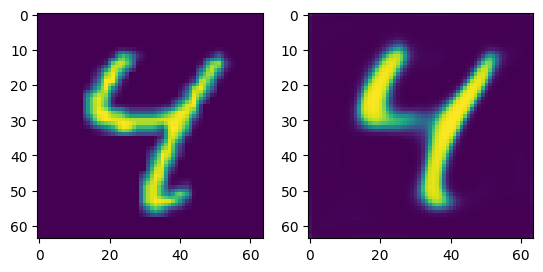

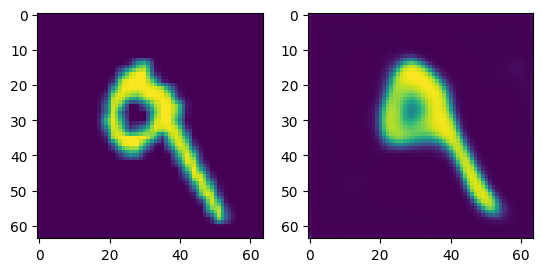

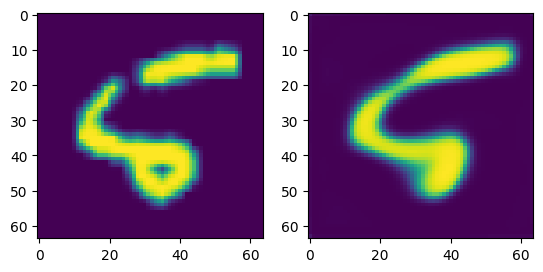

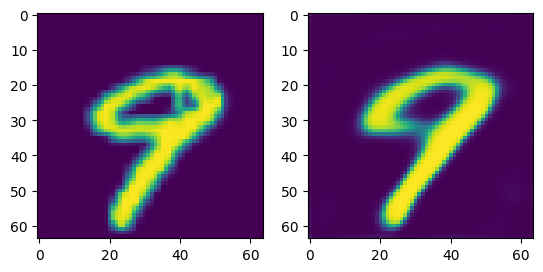

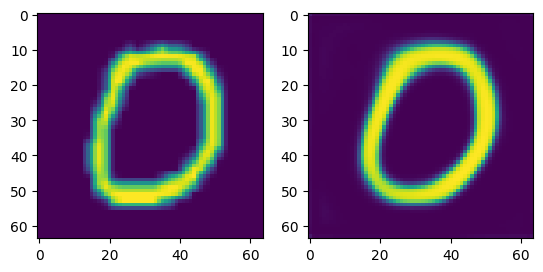

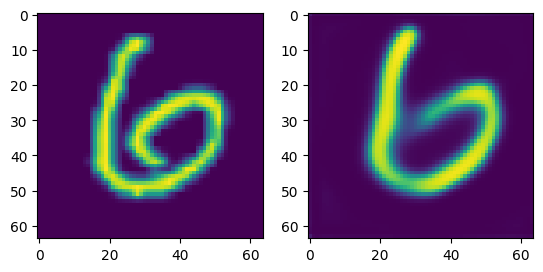

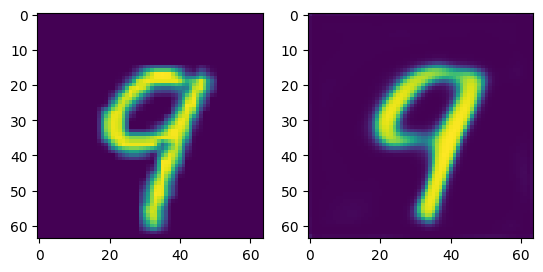

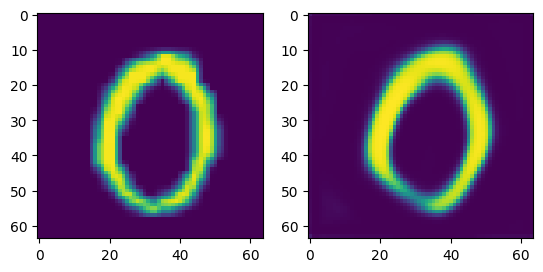

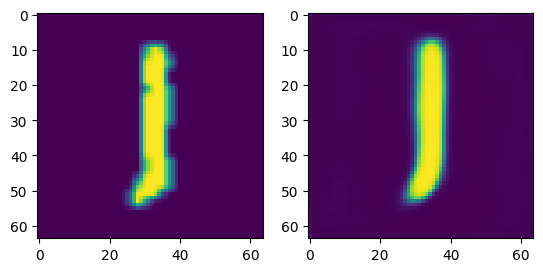

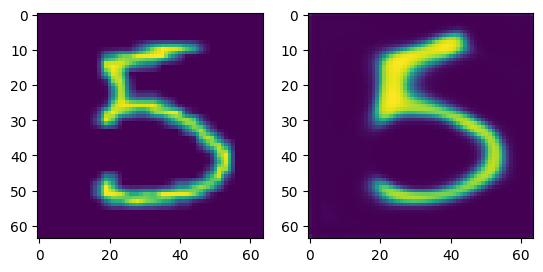

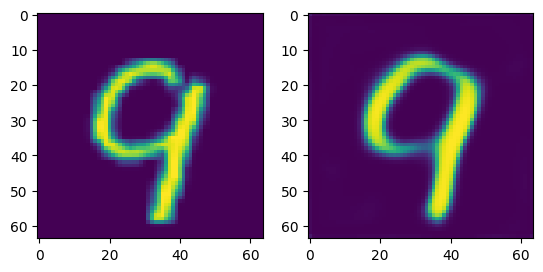

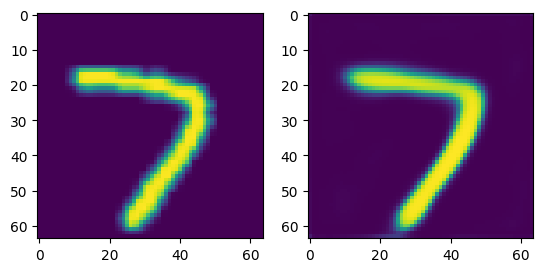

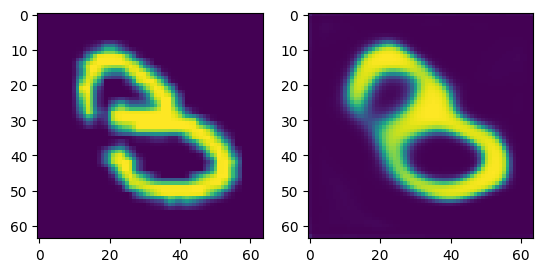

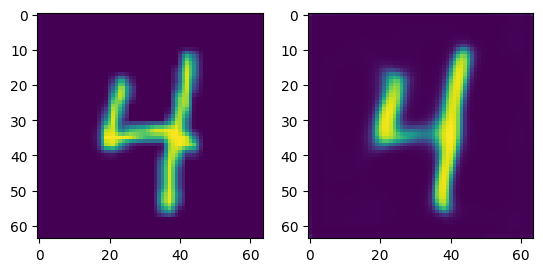

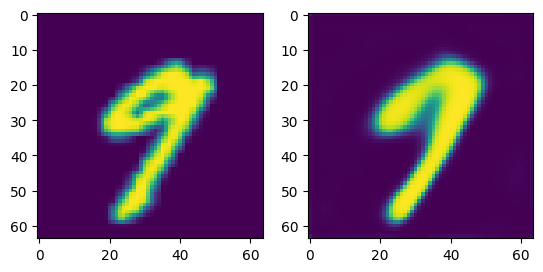

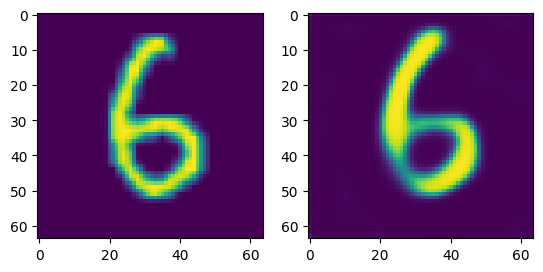

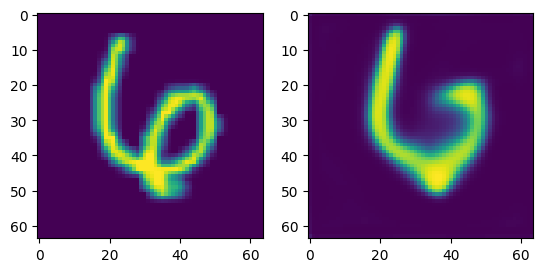

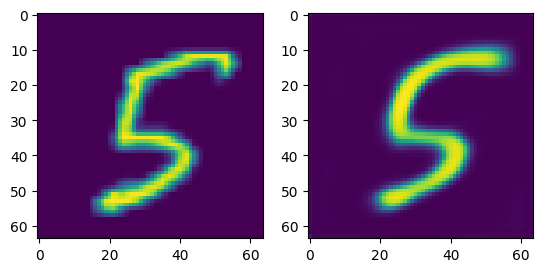

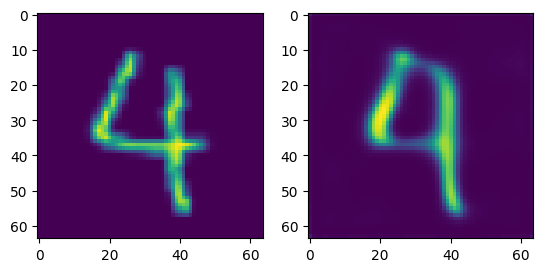

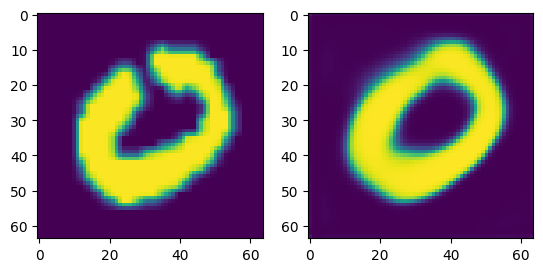

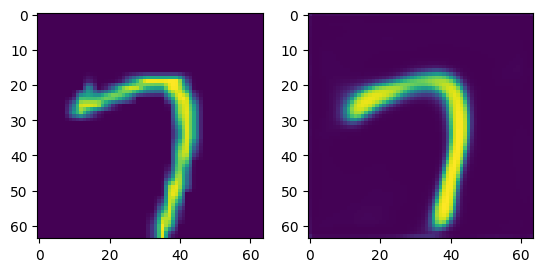

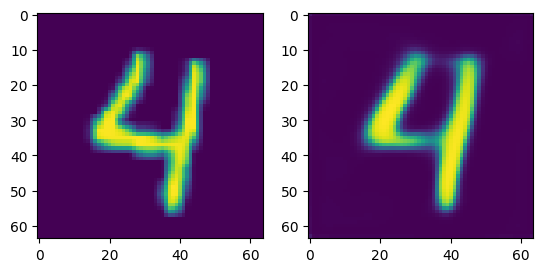

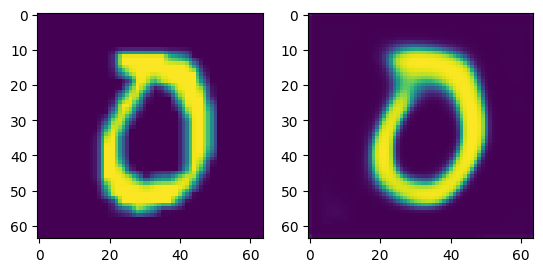

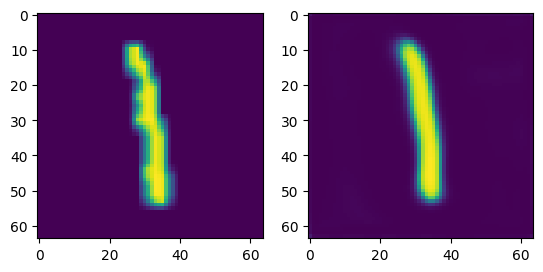

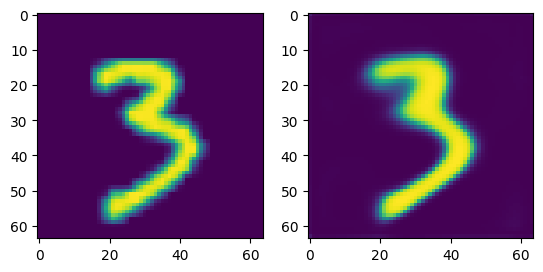

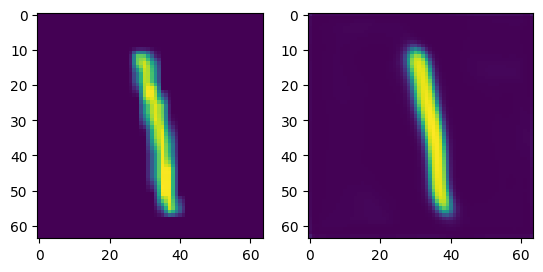

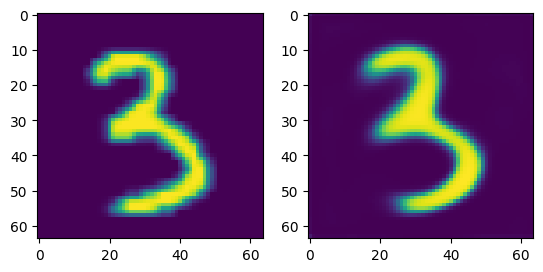

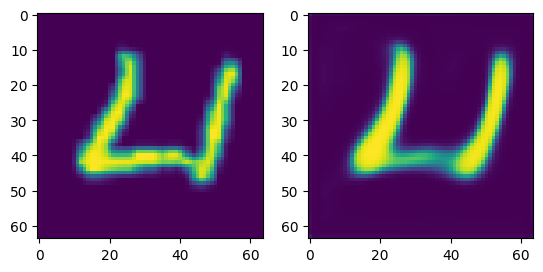

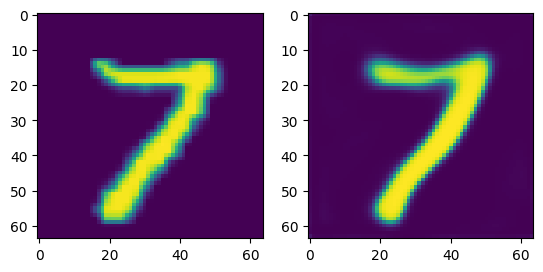

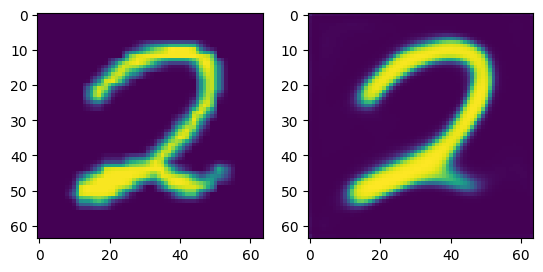

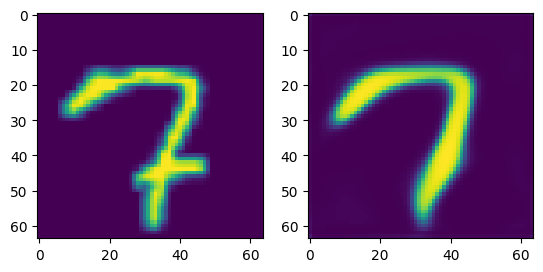

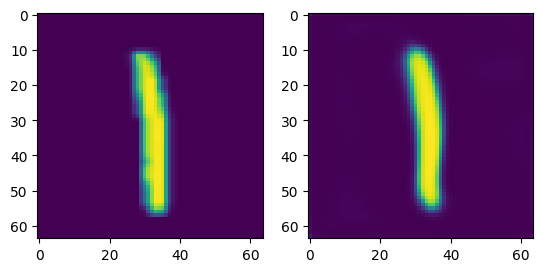

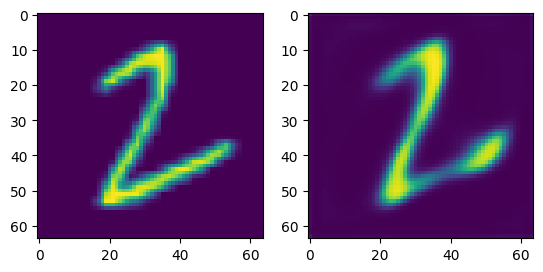

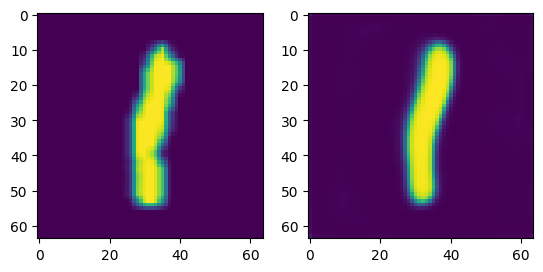

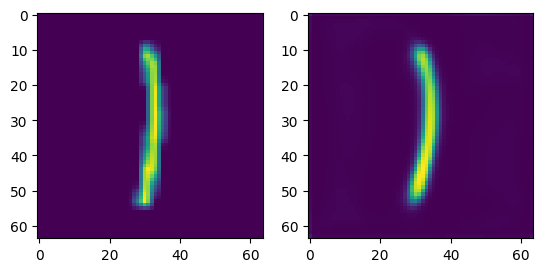

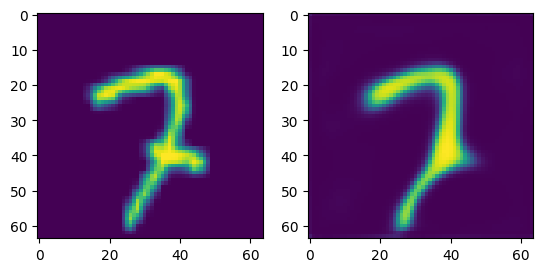

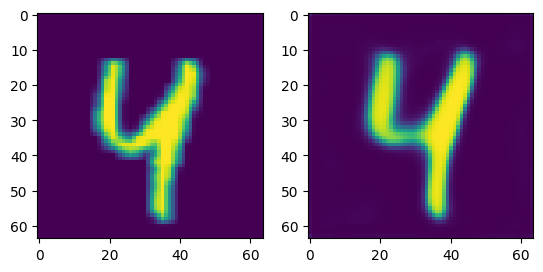

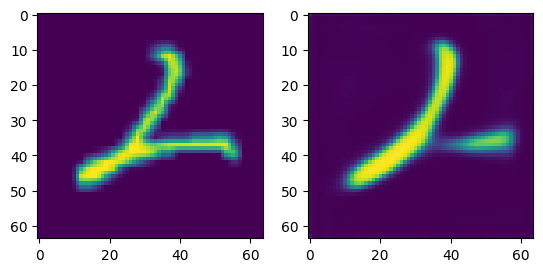

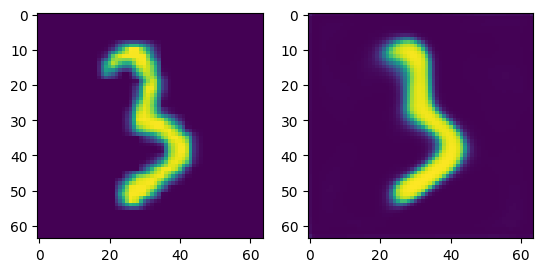

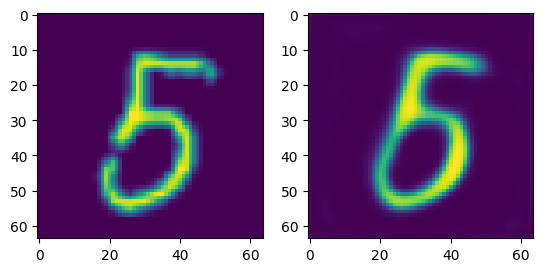

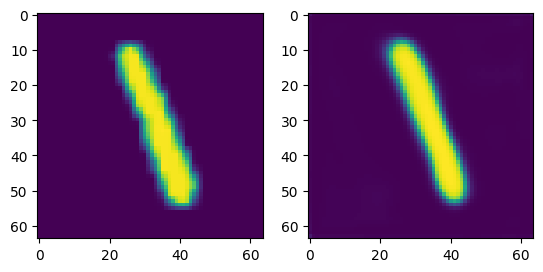

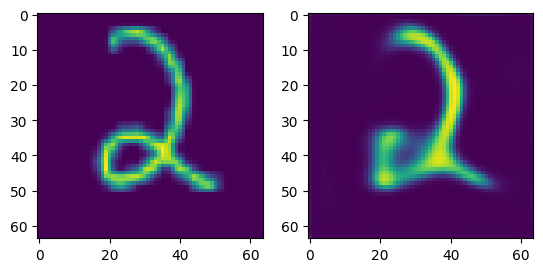

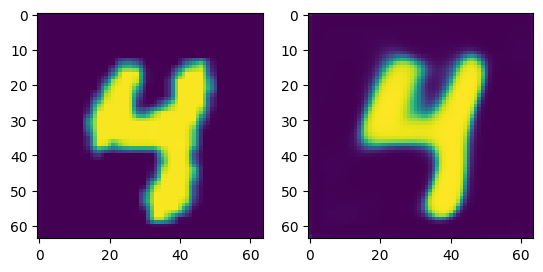

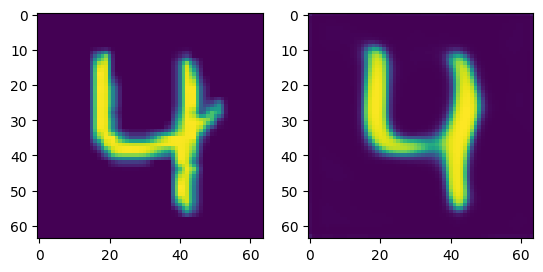

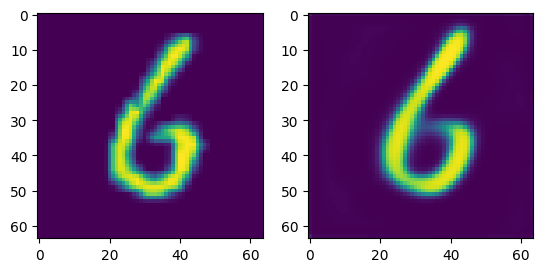

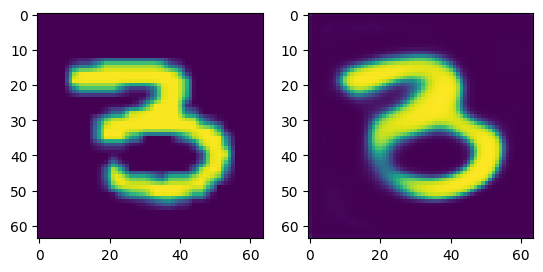

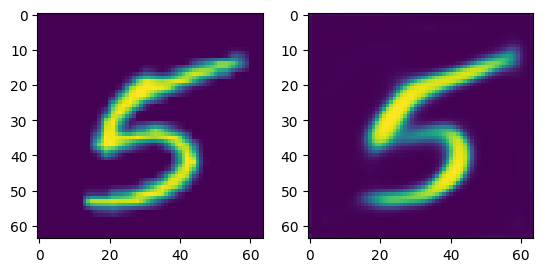

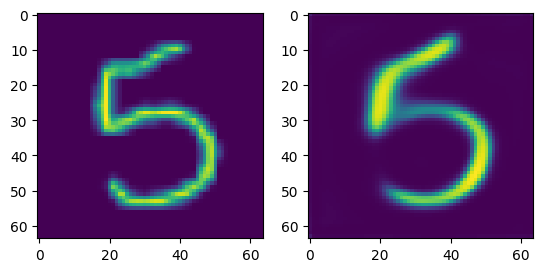

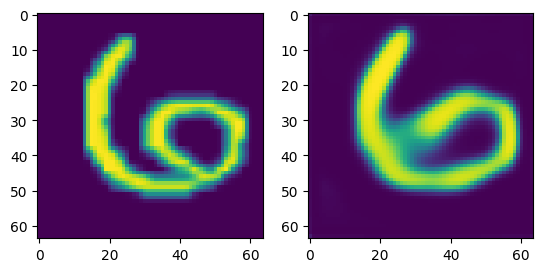

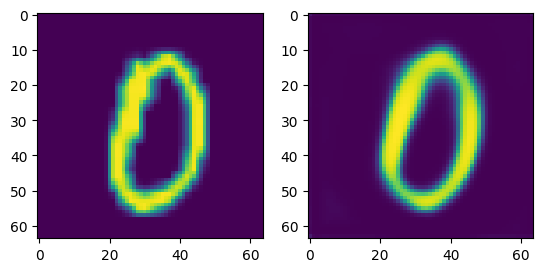

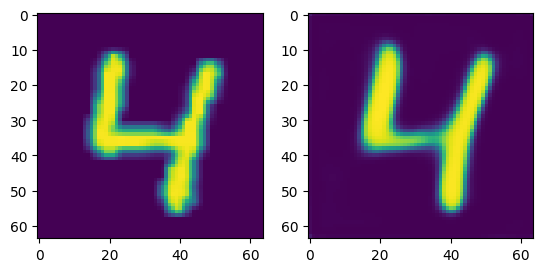

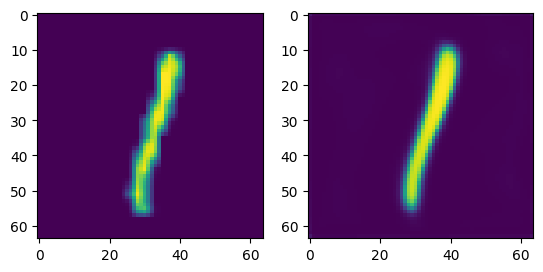

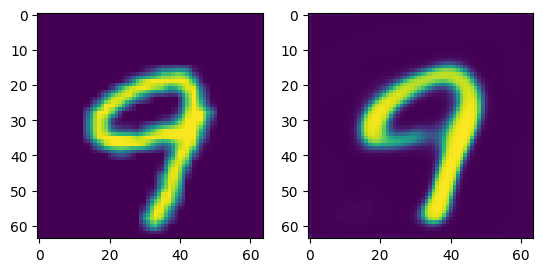

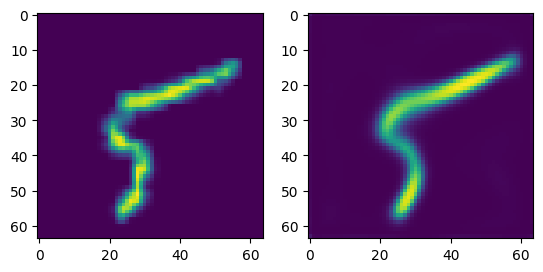

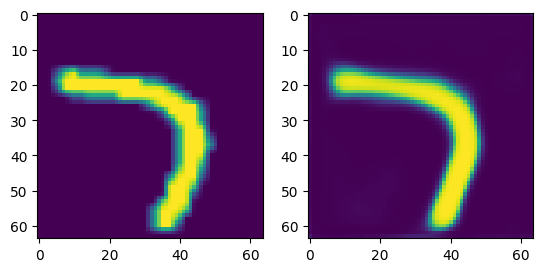

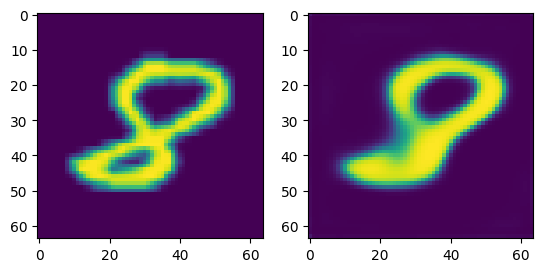

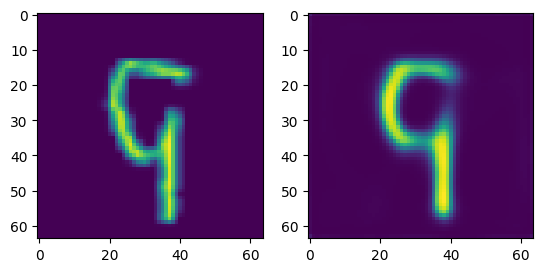

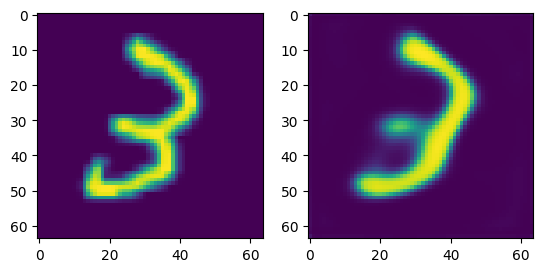

In [ ]:
test_batch = next(iter(test_loader))
ae.eval()

for image in test_batch[0]:
    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze())
    plt.subplot(1, 2, 2)
    plt.imshow(ae(image.unsqueeze(0).to(device)).squeeze().detach().to('cpu'))
    plt.show()